# 03B - Learned Baselines
In this notebook, we implement another baseline model for comparison purposes. The algorithm used is the same as the previous baseline model, namely predicted rating = overall average + user bias + item bias. The difference is that here we utilize the BaselineOnly module from the Surprise library, which treats user bias and item bias as parameters to be learned rather than manually computed.

In [73]:
from surprise import Dataset, evaluate, BaselineOnly, Reader
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK
from sklearn.metrics import roc_auc_score

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time


sns.set(style='whitegrid')
% matplotlib inline

In [7]:
# import data
data_path = os.path.join('..', 'data-2')
splits_path = os.path.join(data_path,'splits')
columns = ['user','item','rating']

with open(os.path.join(splits_path, 'train.df'), 'rb') as file_in:
    train_df = pkl.load(file_in)[columns]
    
with open(os.path.join(splits_path, 'dev.df'), 'rb') as file_in:
    cv_df = pkl.load(file_in)[columns]
    
with open(os.path.join(splits_path, 'train_dev.df'), 'rb') as file_in:
    train_cv_df = pkl.load(file_in)[columns]

with open(os.path.join(splits_path, 'test.df'), 'rb') as file_in:
    test_df = pkl.load(file_in)[columns]

In [8]:
# use the load_from_df function from Suprise's Dataset module. This function requires the rating scale to be specified.
reader = Reader(rating_scale=(1,5))
train_sdf = Dataset.load_from_df(train_df, reader=reader)
cv_sdf = Dataset.load_from_df(cv_df, reader=reader)
train_cv_sdf = Dataset.load_from_df(train_cv_df, reader=reader)
test_sdf = Dataset.load_from_df(test_df, reader=reader)

Surprise's BaselineOnly model can be tuned with three hyperparameters:
1. n_epochs: the number of epochs a model trains for prior to termination
2. reg_i: regularization parameter for item biases
3. reg_u: regularization parameter for user biases

To search for optimal hyperparameter values, we eschew grid search for a more efficient and effective Bayesian optimization method using **tree parzen estimators** provided by the Hyperopt library.

The following two sections first define our objective function on which we would like to optimize (3-fold cross-validated MAE) and then feed this objective function into the fmin function from the Hyperopt library to select a set of optimized hyperparameters.

In [9]:
# define the objective function that the fmin module can later optimize on
def test_baseline(params):
    '''Surprise has a BaselineOnly module that finds the best fit for the given prediction algorithm by
       applying regularization, and here we choose ALS as the method used to compute the baseline estimates. '''
    params['method'] = 'als'
    model = BaselineOnly(bsl_options=params)
    train_cv_sdf.split(5, shuffle=True)
    results = evaluate(model, train_cv_sdf, measures = ['mae'], verbose=True)
    mae = np.array(results['mae']).mean()
    return mae

In [10]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'trials_baseline'), 'rb') as file_in:
        trials = pkl.load(file_in)
    with open(os.path.join(data_path, 'best_baseline.dict'), 'rb') as file_in:
        best = pkl.load(file_in)
else:
    '''set the range of hyperpatameters for the baseline model
       n_epochs: number of iterations the ALS procedure will be performed
       reg_i: regularization parameter for items
       reg_u: regularization parameter for users
    '''
    trials = Trials()
    space = {
        'n_epochs': hp.choice('n_epochs', list(range(5,21))),
        'reg_i': hp.uniform('reg_i', 0, 10),
        'reg_u': hp.uniform('reg_u', 0, 15)
    }
    
    # Choose the Tree-structured Parzen Estimator (TPE) as the algorithm to optimize the objective function
    best = fmin(algo = tpe.suggest,
               fn = test_baseline,
               trials = trials,
               max_evals = 100, # max number of tests
               space = space)
    with open(os.path.join(data_path, 'trials_baseline'), 'wb') as file_out:
        pkl.dump(trials, file_out)
    with open(os.path.join(data_path, 'best_baseline.dict'), 'wb') as file_out:
        pkl.dump(best, file_out)

Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7349
------------
Fold 2
Estimating biases using als...
MAE:  0.7337
------------
Fold 3
Estimating biases using als...
MAE:  0.7375
------------
Fold 4
Estimating biases using als...
MAE:  0.7349
------------
Fold 5
Estimating biases using als...
MAE:  0.7375
------------
------------
Mean MAE : 0.7357
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7376
------------
Fold 2
Estimating biases using als...
MAE:  0.7386
------------
Fold 3
Estimating biases using als...
MAE:  0.7414
------------
Fold 4
Estimating biases using als...
MAE:  0.7383
------------
Fold 5
Estimating biases using als...
MAE:  0.7439
------------
------------
Mean MAE : 0.7399
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7505
------------
Fold 2
Estimat

------------
Fold 1
Estimating biases using als...
MAE:  0.7428
------------
Fold 2
Estimating biases using als...
MAE:  0.7392
------------
Fold 3
Estimating biases using als...
MAE:  0.7411
------------
Fold 4
Estimating biases using als...
MAE:  0.7442
------------
Fold 5
Estimating biases using als...
MAE:  0.7457
------------
------------
Mean MAE : 0.7426
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7262
------------
Fold 2
Estimating biases using als...
MAE:  0.7225
------------
Fold 3
Estimating biases using als...
MAE:  0.7271
------------
Fold 4
Estimating biases using als...
MAE:  0.7264
------------
Fold 5
Estimating biases using als...
MAE:  0.7227
------------
------------
Mean MAE : 0.7250
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7260
------------
Fold 2
Estimating biases using als...
MAE:  0.7232
------

------------
Fold 1
Estimating biases using als...
MAE:  0.7301
------------
Fold 2
Estimating biases using als...
MAE:  0.7268
------------
Fold 3
Estimating biases using als...
MAE:  0.7302
------------
Fold 4
Estimating biases using als...
MAE:  0.7293
------------
Fold 5
Estimating biases using als...
MAE:  0.7316
------------
------------
Mean MAE : 0.7296
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7304
------------
Fold 2
Estimating biases using als...
MAE:  0.7297
------------
Fold 3
Estimating biases using als...
MAE:  0.7287
------------
Fold 4
Estimating biases using als...
MAE:  0.7307
------------
Fold 5
Estimating biases using als...
MAE:  0.7294
------------
------------
Mean MAE : 0.7298
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7282
------------
Fold 2
Estimating biases using als...
MAE:  0.7320
------

------------
Fold 1
Estimating biases using als...
MAE:  0.7406
------------
Fold 2
Estimating biases using als...
MAE:  0.7434
------------
Fold 3
Estimating biases using als...
MAE:  0.7390
------------
Fold 4
Estimating biases using als...
MAE:  0.7426
------------
Fold 5
Estimating biases using als...
MAE:  0.7447
------------
------------
Mean MAE : 0.7420
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7250
------------
Fold 2
Estimating biases using als...
MAE:  0.7292
------------
Fold 3
Estimating biases using als...
MAE:  0.7268
------------
Fold 4
Estimating biases using als...
MAE:  0.7283
------------
Fold 5
Estimating biases using als...
MAE:  0.7272
------------
------------
Mean MAE : 0.7273
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7437
------------
Fold 2
Estimating biases using als...
MAE:  0.7444
------

------------
Fold 1
Estimating biases using als...
MAE:  0.7316
------------
Fold 2
Estimating biases using als...
MAE:  0.7349
------------
Fold 3
Estimating biases using als...
MAE:  0.7376
------------
Fold 4
Estimating biases using als...
MAE:  0.7275
------------
Fold 5
Estimating biases using als...
MAE:  0.7343
------------
------------
Mean MAE : 0.7332
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7393
------------
Fold 2
Estimating biases using als...
MAE:  0.7421
------------
Fold 3
Estimating biases using als...
MAE:  0.7410
------------
Fold 4
Estimating biases using als...
MAE:  0.7419
------------
Fold 5
Estimating biases using als...
MAE:  0.7436
------------
------------
Mean MAE : 0.7416
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7310
------------
Fold 2
Estimating biases using als...
MAE:  0.7287
------

------------
Fold 1
Estimating biases using als...
MAE:  0.7353
------------
Fold 2
Estimating biases using als...
MAE:  0.7378
------------
Fold 3
Estimating biases using als...
MAE:  0.7379
------------
Fold 4
Estimating biases using als...
MAE:  0.7378
------------
Fold 5
Estimating biases using als...
MAE:  0.7408
------------
------------
Mean MAE : 0.7379
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7363
------------
Fold 2
Estimating biases using als...
MAE:  0.7394
------------
Fold 3
Estimating biases using als...
MAE:  0.7395
------------
Fold 4
Estimating biases using als...
MAE:  0.7420
------------
Fold 5
Estimating biases using als...
MAE:  0.7399
------------
------------
Mean MAE : 0.7394
------------
------------
Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7375
------------
Fold 2
Estimating biases using als...
MAE:  0.7383
------

This section below, accompanied by various graphs, visualizes the distribution of the different values each hyperparameter can take and the corresponding loss values.

In [11]:
def val_diagnostic(val_name, trials):
    '''generates scatter plot and histogram of each parameter, as well as a plot on loss values (MAE)'''
    
    vals = np.array([trial['misc']['vals'][val_name] for trial in trials.trials])
    
    '''For hyperparameters that are specified with hp.choice, such as a range of integers,
       Hyperopt returns the index of the tested hyperparameter value rather than the value itself.
       Thus, for hyperparameter ranges that begin at a non-zero point,
       it is necessary to shift the indices to the corresponding values they represent.
    '''
    if val_name == 'n_epochs':
        vals += 5
    elif val_name == 'n_factors':
        vals += 10
        
    ts = [trial['tid'] for trial in trials.trials]
    results = [trial['result']['loss'] for trial in trials.trials]
    
    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    axes[0].scatter(ts, vals)
    axes[0].set(xlabel='iteration', ylabel=val_name)
    axes[1].hist(np.array(vals).squeeze())
    axes[1].set(xlabel=val_name, ylabel='frequency')
    axes[2].scatter(vals, results)
    axes[2].set(xlabel=val_name, ylabel='loss')
    plt.tight_layout()

For each hyperparameter, namely number of epochs and regularization parameters for user and item, we make three plots to understand its distribution and performance. The first and second graphs are respectively a scatterplot and a histogram, in order to visualize where the values tend to cluster as the model optimizes. The third graph is a loss vs. values plot that visualizes how MAE changes with different values. The model picks the combination of hyperparameter values where loss is minimized.

In the case of the baseline with ALS, it appears that larger values of **n_epochs** leads to marginally better performance, while no regularization results in the best performance.

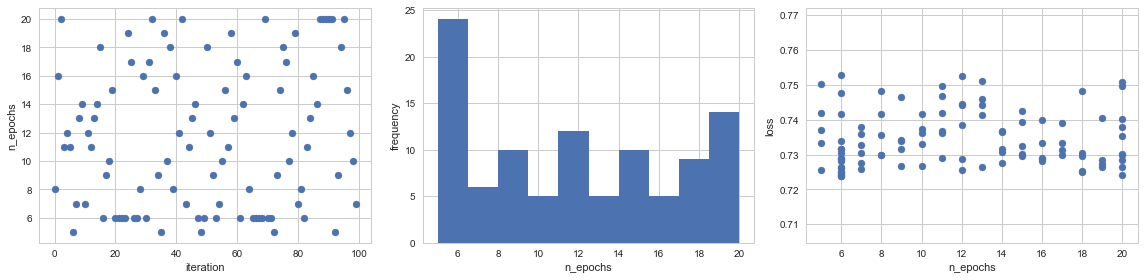

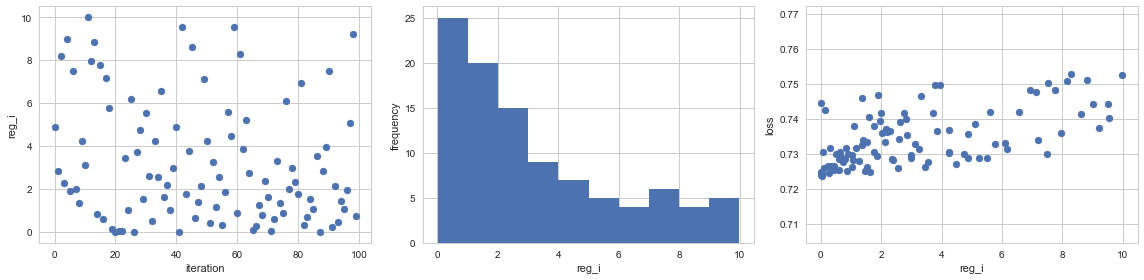

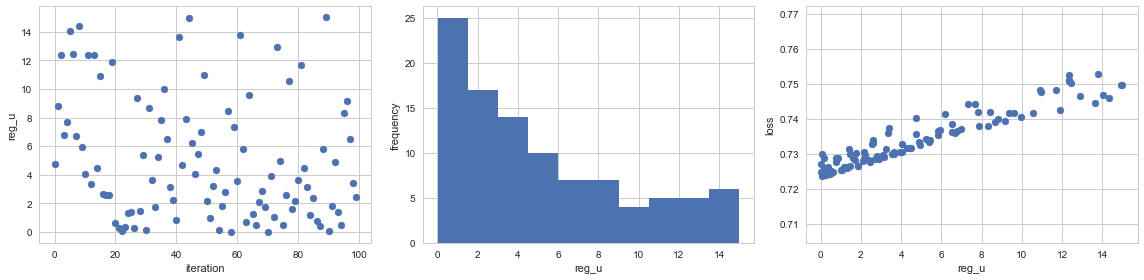

In [12]:
for val in trials.trials[0]['misc']['vals'].keys():
    val_diagnostic(val, trials)

In [19]:
# optimized hyperparameter values
best_opt = best.copy()
best_opt['n_epochs'] += 5
best_opt['method'] = 'als'
best_opt['reg_i'] = 0
best_opt['reg_u'] = 0
best_opt

{'method': 'als', 'n_epochs': 6, 'reg_i': 0, 'reg_u': 0}

In [20]:
# evaluate results for 5 iterations using baseline ALS with optimized hyperparameters
train_cv_sdf.split(5)
model_opt = BaselineOnly(bsl_options=best_opt)
results_opt = evaluate(model_opt, train_cv_sdf, measures = ['mae'])

Evaluating MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
MAE:  0.7231
------------
Fold 2
Estimating biases using als...
MAE:  0.7232
------------
Fold 3
Estimating biases using als...
MAE:  0.7252
------------
Fold 4
Estimating biases using als...
MAE:  0.7230
------------
Fold 5
Estimating biases using als...
MAE:  0.7260
------------
------------
Mean MAE : 0.7241
------------
------------


After finding the optimized hyperparameters and the best regularization parameters, we find the median MAE of the learned baseline model to be around 0.724.

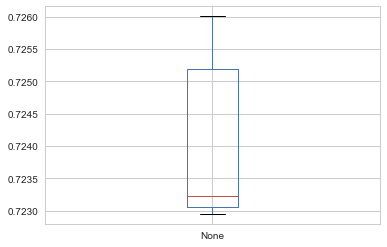

In [21]:
# make a box plot of the results
pd.Series(results_opt['mae']).plot(kind = 'box')

# Generate output for ensembling

In [31]:
model_opt.train(train_sdf.build_full_trainset())

Estimating biases using als...


In [44]:
def make_predictions(model, data):
    pred_list = list()
    out_data = data.copy()
    for row_index in range(data.shape[0]):
        row = data.iloc[row_index,:]
        user = row['user']
        item = row['item']
        rating_pred = model.predict(iid=item, uid=user)
        pred_list.append(rating_pred.est)
    out_data['pred'] = np.array(pred_list)
    return out_data

In [55]:
use_pretrained = True

if use_pretrained:
    train_results_df = pd.read_csv(os.path.join(data_path, 'results_baseline_train.csv'))
    cv_results_df = pd.read_csv(os.path.join(data_path, 'results_baseline_cv.csv'))
    test_results_df = pd.read_csv(os.path.join(data_path, 'results_baseline_test.csv'))
else:
    train_results_df = make_predictions(model_opt, train_df)
    train_results_df.to_csv(os.path.join(data_path, 'results_baseline_train.csv'),
                            header=True, index=False, encoding='utf-8')
    cv_results_df = make_predictions(model_opt, cv_df)
    cv_results_df.to_csv(os.path.join(data_path, 'results_baseline_cv.csv'),
                            header=True, index=False, encoding='utf-8')
    test_results_df = make_predictions(model_opt, test_df)
    test_results_df.to_csv(os.path.join(data_path, 'results_baseline_test.csv'),
                        header=True, index=False, encoding='utf-8')

# Results

mean absolute error, training set: 0.690114971051138
mean absolute error, cross-validation set: 0.7254507867153669
mean absolute error, test set: 0.7187408260182659


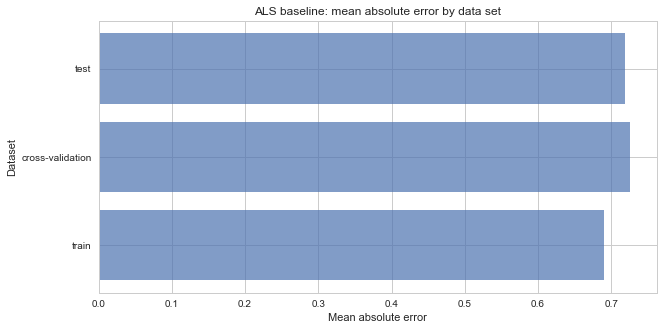

In [72]:
mae_train = np.abs(train_results_df['rating'] - train_results_df['pred']).mean()
mae_cv = np.abs(cv_results_df['rating'] - cv_results_df['pred']).mean()
mae_test = np.abs(test_results_df['rating'] - test_results_df['pred']).mean()

print('mean absolute error, training set:', mae_train)
print('mean absolute error, cross-validation set:', mae_cv)
print('mean absolute error, test set:', mae_test)

mae_list = [mae_train, mae_cv, mae_test]

plt.figure(figsize = (10, 5))
ax = plt.barh([0,1,2], mae_list, alpha = 0.7)
plt.gca().set(yticks = [0,1,2], yticklabels = ['train', 'cross-validation', 'test'])
plt.gca().set(title = 'ALS baseline: mean absolute error by data set',
              ylabel = 'Dataset', xlabel = 'Mean absolute error')

In [75]:
def calc_auc(data):
    y = data['rating'] >= 4
    y_pred = data['pred'] / data['pred'].max()
    auc = roc_auc_score(y, y_pred)
    return auc

mean absolute error, training set: 0.842966643292
mean absolute error, cross-validation set: 0.8145280317
mean absolute error, test set: 0.82065105661


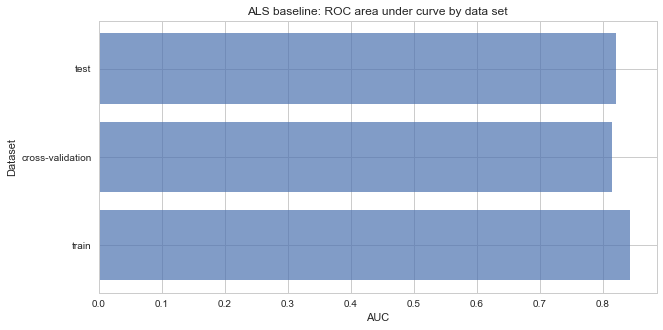

In [76]:
auc_train = calc_auc(train_results_df)
auc_cv = calc_auc(cv_results_df)
auc_test = calc_auc(test_results_df)

print('mean absolute error, training set:', auc_train)
print('mean absolute error, cross-validation set:', auc_cv)
print('mean absolute error, test set:', auc_test)

auc_list = [auc_train, auc_cv, auc_test]

plt.figure(figsize = (10, 5))
ax = plt.barh([0,1,2], auc_list, alpha = 0.7)
plt.gca().set(yticks = [0,1,2], yticklabels = ['train', 'cross-validation', 'test'])
plt.gca().set(title = 'ALS baseline: ROC area under curve by data set',
              ylabel = 'Dataset', xlabel = 'AUC')